<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Define-the-state-machine" data-toc-modified-id="Define-the-state-machine-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Define the state machine</a></span><ul class="toc-item"><li><span><a href="#Define-the-data-structures" data-toc-modified-id="Define-the-data-structures-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Define the data structures</a></span></li><li><span><a href="#Define-the-state-functions-and-the-state-machine-itself" data-toc-modified-id="Define-the-state-functions-and-the-state-machine-itself-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Define the state functions and the state machine itself</a></span></li></ul></li><li><span><a href="#Program-execution" data-toc-modified-id="Program-execution-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Program execution</a></span><ul class="toc-item"><li><span><a href="#Adjusting-camera-position" data-toc-modified-id="Adjusting-camera-position-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Adjusting camera position</a></span></li><li><span><a href="#Execute-Program" data-toc-modified-id="Execute-Program-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Execute Program</a></span></li></ul></li></ul></div>

### Imports
All the imports necessary to run the program. This includes user defined files and library files.

In [1]:
#!pip install pyserial
#import standart libraries
import os
import sys
import time
import serial
import numpy as np
from numpy import linalg as LNG 
import math
import cv2
import matplotlib.pyplot as plt
from matplotlib import colors
from PIL import Image
from skimage import exposure
from timeit import default_timer as timer

# Adding the src folder in the current directory as it contains the script
# with the Thymio class and all the files with the group generated functions and classes
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))
from Thymio import Thymio
#import functions made by group
from pathPlanning import pathPlaning
import ANN
import robot_control
import Vision
import sys

from kalman_filter import kalman_filt

### Define the state machine
In this section the state machine shown earlier is realized in code. To achieve that, 2 data structures are needed, one that holds the names of the states and one that holds all the data needed to make the decisions and afterwards the state functions are defined.

#### Define the data structures
The first data structure holds the state names used in the state machine. This is basically what in other languages is an enumeration or static variables. The second class is used to store data from the sensors and then only needing to hand over the object of this class, containing all the data needed to make decisions.

In [2]:
#class used to store the names of the states to be able to retrive the state functions from the dictionary 
#that serves as state machine
class stateNames_t:
    def __init__(self):
        self.planAcquired='planAcquired'
        self.newPath='newpath'
        self.checkingPath='checkingPath'
        self.underWay='underWay'
        self.obstacleAvoidance='obstalceAvoidance'
        self.goalReached='goalReached'
#this class is used as data transfer between the data acqusition part, the decision making part and the control part.
class FSMHelper:
    def __init__(self,thymio,equalTolerance,wayPointDistance,pathplanner):
        self.wasKidnapped=False
        self.tolerance=equalTolerance
        self.currentPosition=np.zeros((2,1))
        self.pathPlanner=pathplanner
        self.newPositionEstimate=0    
        self.thymio=thymio      
        self.obstacleDetected=False
        self.doStop=False
        self.goalReached=False
        self.goal=np.zeros((2,1))
        self.pathToFollow=np.array([[0],[0]])
        self.FSMStates=stateNames_t()
        self.straightenedImage=0
        self.wayPointReachedDistance=wayPointDistance
        self.followPath=False
        

#### Define the state functions and the state machine itself
In this sections all the state functions are defined. Each function is called when the state it represents is entered. Each state function then returns the name of the next state, that should be entered. This makes it possible that the state machine is a dictionary with the state names as keys and the state functions as items. To make the state machine to its job, the item with the current state name has to be retrieved, the state function, and executed. The name given by the executed state function is then the next state and the same can be done again.

In [3]:
def planAcquired(robot):     #starting state, the map is generated and preprocessed to enable path generation
    return robot.FSMStates.checkingPath      #go to check if a new path needs to be generated
    
def newPath(robot):#
    robot.pathToFollow=robot.pathPlanner.getOptimizedPath()
    print("path after Planner",robot.pathToFollow)
    return robot.FSMStates.checkingPath
    
def checkingPath(robot):
    if(np.size(robot.pathToFollow)!=0):
        robot.followPath=True
        return robot.FSMStates.underWay
    else:
        robot.followPath=False
        robot.doStop=True
        return robot.FSMStates.goalReached
    
def underWay(robot):
    if(robot.obstacleDetected==True):
        robot.followPath=False
        return robot.FSMStates.obstacleAvoidance
    else:
        return robot.FSMStates.planAcquired
    
def avoidObstacle(robot):     
    ANN.run_ann_without_memory(robot.thymio)
    return robot.FSMStates.checkingPath 

def goalReached(robot):
    robot.goalReached=True
    
    
#define the concrete stateName object to make the dictionary for the actual state machine
stateName=stateNames_t()
switch = {
    stateName.planAcquired     : planAcquired,
    stateName.newPath          : newPath,
    stateName.checkingPath     : checkingPath,
    stateName.underWay         : underWay,
    stateName.obstacleAvoidance: avoidObstacle,
    stateName.goalReached      : goalReached,
}
currentState=stateName.planAcquired
futureState=stateName.planAcquired

### Program execution

Now that the data structures needed to run the state machine and the state machine itself is defined in code, the program can be executed.

#### Adjusting camera position
<img src="documentation\ImagesForDocumentation/exampleMap.jpg"
     alt="Example Picture of camera view"
     style="float: left; margin-right: 5px;width: 500px;" />
The camera should see an image similar to the one shown here. All 4 red corner markers should be visible, the map should also fill out most of the image of the camera. It is also necessary that the colors are well visible and that the picture is not too bright. To help with this adjustment execute the code in the next cell. The exposure setting of the camera can be adjusted, with the presses of "w" and "s". Just don't press to fast. The values are printed.

In [4]:
cameraIndex=1             #index 1 is the index of the specific machine used. it is highly likly that it is on other machines aswell
cv2.namedWindow("preview")
exposureOfCamera=-2.1
videoCapture = cv2.VideoCapture(cameraIndex)
if not(videoCapture.isOpened()):
    raise Exception('could not connect to camera')
videoCapture = cv2.VideoCapture(cameraIndex)
exposureOfCamera=-2.1          #initial exposure
videoCapture.set(cv2.CAP_PROP_EXPOSURE,exposureOfCamera)
videoCapture.set(cv2.CAP_PROP_SATURATION ,120)

if not(videoCapture.isOpened()):
    raise Exception('could not connect to camera')

if videoCapture.isOpened(): # try to get the first frame
    rval, frame = videoCapture.read()
else:
    rval = False
    raise Exception('could not connect to camera')
while rval:
    cv2.imshow("preview", frame)
    rval, frame = videoCapture.read()
    key = cv2.waitKey(20)
    if key == 27: # exit on ESC
        break
    elif(key== ord('w')):
        exposureOfCamera=exposureOfCamera+0.1
        print (videoCapture.set(cv2.CAP_PROP_EXPOSURE,exposureOfCamera),exposureOfCamera)
    elif(key== ord('s')):    
        exposureOfCamera=exposureOfCamera-0.1
        print (videoCapture.set(cv2.CAP_PROP_EXPOSURE,exposureOfCamera),exposureOfCamera)
cv2.destroyWindow("preview")
cv2.destroyAllWindows()
cv2.VideoCapture(cameraIndex).release()

#### Execute Program
In this section the main control loop and the initialization can be executed. Connecting to the thymio should only be executed once.

In [5]:
th=Thymio.serial(port="COM6", refreshing_rate=0.1)

If the next cell is executed the thymio will begin moving after a certain amount of time. This waiting time is because of the map generation

Endpoint Coordinates:  (104.96265972187071, 10.27041700063182)


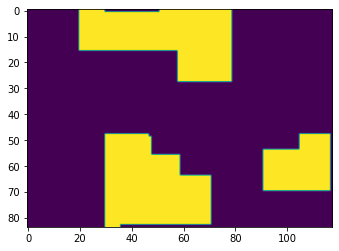

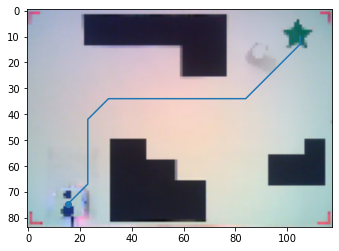

---------------------------------------------------------WAYPOINT REACHED
---------------------------------------------------------WAYPOINT REACHED
---------------------------------------------------------WAYPOINT REACHED
---------------------------------------------------------WAYPOINT REACHED
---------------------------------------------------------WAYPOINT REACHED
---------------------------------------------------------WAYPOINT REACHED
---------------------------------------------------------WAYPOINT REACHED
GOAL REACHED


In [6]:
#########if exposure was adjusted fill in the value printted into the console into this variable instead of the -2.1
exposureOfCamera=-2.1
#------- turn off all leds that can be controlled
th.set_var_array("leds.top", [0, 0, 0])
th.set_var_array("leds.bottom.right", [0, 0, 0])
th.set_var_array("leds.bottom.left", [0, 0, 0])
demonstrationSize=4        #how many times the size of 118 by 84 the picture should be presented

#------ start camera
cameraIndex=1             #index 1 is the index of the specific machine used. it is highly likly that it is on other machines aswell
videoCapture = cv2.VideoCapture(cameraIndex)
#-------set exposure to have a bright enough picture
videoCapture.set(cv2.CAP_PROP_EXPOSURE,exposureOfCamera)
if videoCapture.isOpened(): # try to get the first frame
    rval, frame = videoCapture.read()
else:
    rval = False
    raise Exception('could not read image!')

mask= cv2.imread('Images/cornerMask.JPG')           #read corner mask
if mask.size==0:
    raise Exception('Could not open Mask')
    
dimension_paper = [118.9,84.1] #cm A0
dim = (int(dimension_paper[1]),int(dimension_paper[0]))
# Switching red and blue channels
frame[:, :, [0, 2]] = frame[:, :, [2, 0]]
mask[:, :, [0, 2]] = mask[:, :, [2, 0]]

#preprocess image data to facilitate map generation and thymio position accusition
p2_1, p98_1 = np.percentile(frame, (2, 98))
img_res1 = exposure.rescale_intensity(frame, in_range=(p2_1,p98_1))
img1_gray = cv2.cvtColor(img_res1, cv2.COLOR_BGR2GRAY)
threshold_bg=130
#------generate map from camera
percent = 0.9
while True:
        output = Vision.bg_clustering(img1_gray, (50,50),threshold_bg)
        corner_location = Vision.corner_detection(output,mask) # Get the location of the 4 corners
        img_straighten, M = Vision.four_point_transform(frame, corner_location) # Get the transformation matrix and the straighten img
        if(img_straighten.shape[0] > output.shape[0]*percent and img_straighten.shape[1] > output.shape[1]*percent):
            break
        else:
            rval, frame = videoCapture.read()
            frame[:, :, [0, 2]] = frame[:, :, [2, 0]]
            

im_dim = img_straighten.shape
obstacles = Vision.get_obstacles(img_straighten) 
thymio_coord = Vision.get_thymio_info(frame,M,dim,im_dim) 
endpoint_coord = Vision.get_endpoint_info(frame,M,dim,im_dim)
low_res_img = cv2.resize(img_straighten, dsize=((dim[1], dim[0])))

#---------make occupancy grid from map
occupancyGrid=cv2.resize(obstacles, dsize=((dim[1], dim[0])))
occupancyGrid=occupancyGrid>200
plt.imshow(occupancyGrid)
plt.show()
occupancyGrid=occupancyGrid.astype(float)
kernel2 = np.ones((7,7), np.uint8)
occupancyGrid = cv2.dilate(occupancyGrid, kernel2, iterations=2)

pathPlanner=pathPlaning(occupancyGrid.copy(),1,1)

#give over the thymio connection and the tolerance for equality to 1e-6, the distance when it is considered way point reached
#and the path planner to use
robotStatus=FSMHelper(th,1e-6,0.5,pathPlanner)
robot_control.th=th      #give pathfollower the connection to the thymio
#---------start planning
robotStatus.pathPlanner.setGoal(np.asarray(endpoint_coord))
robotStatus.currentPosition=np.array([(thymio_coord[0][0]),(thymio_coord[0][1]),(thymio_coord[1])/180*np.pi])
robotStatus.pathPlanner.setStart(robotStatus.currentPosition[0:2])
robotStatus.pathToFollow=robotStatus.pathPlanner.getOptimizedPath()
estimatedRobotPose=robotStatus.currentPosition

#show path on image
originalPath=robotStatus.pathToFollow.copy() 
plt.imshow(low_res_img)
plt.scatter(thymio_coord[0][0],thymio_coord[0][1])
plt.plot(originalPath[0],originalPath[1])
plt.show()
#-------------path planning and map generation complete
%matplotlib qt

#constant kalman matrixes
A = np.array([[1,0,0],[0,1,0],[0,0,1]])
C = np.array([[1,0,0],[0,1,0],[0,0,1]])
Q = np.array([[0.1, 0, 0],[0, 0.1, 0],[0,0,0.1]]) # Dependent on the error (can be linked to stated as velocity, but velocity is not taken as state. )
R = np.array([[0.1, 0, 0],[0, 0.1, 0],[0,0,0.1]])
Q_ini = Q
X = np.array([[estimatedRobotPose[0]],[estimatedRobotPose[1]],[estimatedRobotPose[2]]], dtype = "float32")
L = []

timeElapsed=np.array([0,0], dtype = 'float64')

robotPositionUncertainty=np.zeros((3,3))         #variable to store the accuracy estimate from odmotry

currentState=stateName.planAcquired              #initialize state event
futureState=stateName.planAcquired
originalPath=robotStatus.pathToFollow.copy()    #store path before loop, loop removes waypoint from non original path
doPlotCounter=0                               #variable used to show the image taken of the camera after 10 loop executions
deltaT=0.0                                   # variable used to store the time needed to execute the loop once
tbefore=time.time()                          #deltaT helpers
tnow=0                                       #deltaT helpers

#lists to record data to be able to plot that later on
unfilteredCameraCoordinates=list()
unfilteredOdometrieCoordinates=list()
afterKalmanCoordinates=list()

cutOfDistance=5                 #distance in where successive camera measurments have to be to the last one to be considered stable
cameraDataStableCounter=0       #counter to count how many camera measurments where stable in a row
cameraEstimate=robotStatus.currentPosition    #used to store current camera position estimate
newPositionEstimate=robotStatus.currentPosition
cameraData=True             #flag used to store whether the camera can see the position of the thymio
numberOfStableMeasurments=10    # minimum of measurments after one measument was unstable to be considered stable again
while(True):         #main execution loop
    ##---------------------------------------------read sensors  
    
    #----get robot position from camera
    [frameCaptureSuccesfull,newPicture]=videoCapture.read()
    if(frameCaptureSuccesfull==False):
        raise Exception('could not read from camera')
    newPicture[:, :, [0, 2]] = newPicture[:, :, [2, 0]]
    thymio_coord = Vision.get_thymio_info(newPicture,M,dim,im_dim) # Do these online, and feed info to kalman filter
    
    if(thymio_coord[0][0]<0 or thymio_coord[0][1]<0 ):
        cameraData=False
    else:
        cameraData=True
    #------------------------------Removal of unstable camera data
    
    if(cameraData==True):       #if camera communicates it sees the thymio check if position is stable
        newCameraEstimate=np.array([thymio_coord[0][0],thymio_coord[0][1],thymio_coord[1]/180.0*np.pi])
        unfilteredCameraCoordinates.append((cameraEstimate[0],cameraEstimate[1]))
        
        if(LNG.norm(newCameraEstimate[0:2]-cameraEstimate[0:2])<cutOfDistance):
            cameraDataStableCounter=cameraDataStableCounter+1
                       
        else:
            cameraDataStableCounter=0
        cameraEstimate=newCameraEstimate
   
    #---------get odometrie data
    estimatedRobotPose,robotPositionUncertainty,timeElapsed=robot_control.odometry(robotStatus.currentPosition,robotPositionUncertainty,timeElapsed, robot_control.MAX_SPEED)
    unfilteredOdometrieCoordinates.append((estimatedRobotPose[0],estimatedRobotPose[1]))
    
    
    if(cameraData==True and (LNG.norm(estimatedRobotPose[0:2]-cameraEstimate[0:2])<cutOfDistance or cameraDataStableCounter>numberOfStableMeasurments)):
        newPositionEstimate=cameraEstimate
    else:
        newPositionEstimate=estimatedRobotPose

   
    #------------filtering
    V_left=th["motor.left.speed"]*0.0135
    V_right=th["motor.right.speed"]*0.0135
    v_avg = (V_left + V_right)/2
    v_delta = V_right-V_left

    tnow=time.time()
    deltaT=tnow-tbefore
    tbefore=tnow

    #kalman matrixes
    B = np.array([[(math.cos(newPositionEstimate[2])),0.], [(math.sin(newPositionEstimate[2])), 0.], [0.,math.atan(v_delta*deltaT/9.5)]])
    Z = np.array([[newPositionEstimate[0]],[newPositionEstimate[1]],[newPositionEstimate[2]]], dtype = "float32")
    u = np.array([[v_avg*deltaT],[1]])  
    X=np.array([[robotStatus.currentPosition[0]],[robotStatus.currentPosition[1]],[robotStatus.currentPosition[2]]])
    thymio_position,cov = kalman_filt(X,u,Q_ini,Z,A,B,C,Q,R)
    Q_ini = cov
    robotStatus.currentPosition=newPositionEstimate
    afterKalmanCoordinates.append((robotStatus.currentPosition[0],robotStatus.currentPosition[1]))
                                       
                                       
    #------------check if unexcpected obstacle is present
    robotStatus.obstacleDetected=not(all(sensorValues==0 for sensorValues in robotStatus.thymio["prox.horizontal"]))
   
    #------------------------------make desicions and work with the collected data 
    
    
    
    stateToExecute=switch.get(currentState)

    futureState=stateToExecute(robotStatus)
    
    #--------------------------------controll the robot
    
    #stopping robot if goal reached end programm
    if(robotStatus.followPath==True and np.size(robotStatus.pathToFollow)!=0):
        _,robotStatus.pathToFollow=robot_control.path_following(robotStatus.currentPosition,robotStatus.pathToFollow)
    if(robotStatus.doStop==True):
        robotStatus.thymio.set_var("motor.left.target", 0)
        robotStatus.thymio.set_var("motor.right.target", 0)
    if(robotStatus.goalReached==True):
        robotStatus.thymio.set_var("motor.left.target", 0)
        robotStatus.thymio.set_var("motor.right.target", 0)
        break
    currentState=futureState
    doPlotCounter=doPlotCounter+1
    
    
    
    #----------------------------------do live plotting
    if(doPlotCounter>10 or robotStatus.goalReached==True):
        
        doPlotCounter=0
        low_res_img = cv2.resize(newPicture, dsize=((int(dim[1]*demonstrationSize), int(dim[0]*demonstrationSize))))
        low_res_img[:, :, [0, 2]] = low_res_img[:, :, [2, 0]]
        low_res_img = cv2.circle(low_res_img, (int(robotStatus.currentPosition[0]*demonstrationSize),int(robotStatus.currentPosition[1]*demonstrationSize)), radius=2, color=(0, 0, 255), thickness=-1)
        low_res_img = cv2.circle(low_res_img, (int(cameraEstimate[0]*demonstrationSize),int(cameraEstimate[1]*demonstrationSize)), radius=10, color=(0, 255, 0), thickness=2)
        low_res_img = cv2.circle(low_res_img, (int(estimatedRobotPose[0]*demonstrationSize),int(estimatedRobotPose[1]*demonstrationSize)), radius=8, color=(255, 0, 0), thickness=2)
        
        cv2.imshow("Display window",low_res_img)
        cv2.waitKey(1)
            

#-----------------------------------plot collected data
unfilteredOdometrieCoordinates=np.array(unfilteredOdometrieCoordinates).reshape(-1, 2).transpose()
afterKalmanCoordinates=np.array(afterKalmanCoordinates).reshape(-1, 2).transpose()
unfilteredCameraCoordinates=np.array(unfilteredCameraCoordinates).reshape(-1, 2).transpose()
plt.scatter(unfilteredCameraCoordinates[0]*demonstrationSize,unfilteredCameraCoordinates[1]*demonstrationSize,label="unfiltered camera")
plt.scatter(unfilteredOdometrieCoordinates[0]*demonstrationSize,unfilteredOdometrieCoordinates[1]*demonstrationSize,label="unfiltered odometrie")                                   
plt.plot(afterKalmanCoordinates[0]*demonstrationSize,afterKalmanCoordinates[1]*demonstrationSize,label="after Filtring")
plt.imshow(low_res_img)
plt.legend()
plt.show()
cv2.waitKey(0)
cv2.destroyAllWindows() 
cv2.VideoCapture(cameraIndex).release()